```
Licensed to the Apache Software Foundation (ASF) under one or more
contributor license agreements.  See the NOTICE file distributed with
this work for additional information regarding copyright ownership.
The ASF licenses this file to You under the Apache License, Version 2.0
(the "License"); you may not use this file except in compliance with
the License.  You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# This jupypter notebook demenstrate how we get the industry vector from company structure data

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
cd ../src

In [54]:
from keras.models import Model
from keras.layers import dot, Input, Activation, Embedding, Flatten, BatchNormalization, LSTM
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import utils
from params import params
import evaluation
from ing_models import industry_embedding_model_build
from ing_models import industry_embedding_model_fit


In [ ]:
cd ..

# Download GLOVE 

In [ ]:
# %%bash
# cd data
# wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
# unzip glove.840B.300d.zip
# cd ..

# Load data

A dummy file of industry_data.csv. The first column is parent company industry code code, and the second column is a list of industry code of all children. This file is used to generate industry code pair
```
naics;industry_list
522110;[522110, 522110, 522110, 522110, 999990]
511210;[334613, 561499, 423430, 541511]
523999;[523999, 561499, 522190, 561990, 531210, 237210, 561990, 999990]
236220;[236115, 531390, 237130, 531390, 531390, 523999]
424340;[339930, 523999, 424340, 523999, 812990]
```

A dummy file of industry_data.csv. The first column is the industry code, and the second column is the number of occurence of the industry code in all company trees. This file is 
```
naics;cnt
332999;3000
518210;2000
541870;120
236220;500
452111;900
325180;700
315220;200
```

In [23]:
df_context, df_weight = utils.load_data('./data/industry_data.csv', './data/industry_weight.csv')
df_context, df_weight, df_pos, idx2industry, industry2idx = utils.prepare_data(df_context, df_weight, digit=4)

df_desc, dict_digit_desc, digit_l = utils.get_desc_dict('./data/naics_code_description.csv')
df_desc['desc'] = utils.get_desc(df_desc, 'Code', digit_l, dict_digit_desc)

naics_2digit_to_idx, idx_to_naics_2digit = utils.get_2digit_idx_dict('./data/naics_code_description.csv')

embeddings_index = utils.get_glove_embedding_dict('./data/glove.840B.300d.txt')
embedding_matrix, dict_sequence, num_words = \
    utils.get_embedding_vector(df_desc, col_desc='desc', col_naics='Code', embeddings_index=embeddings_index)

df = utils.get_input(df_context,
                     df_weight,
                     df_pos,
                     dict_sequence,
                     naics_col='naics_4_digit',
                     industry2idx=industry2idx,
                     naics_2digit_to_idx=naics_2digit_to_idx)

Found 583 unique tokens.
Shape of data tensor: (434, 30)


In [24]:
df.head()

,naics_4_digit,context,label,target_desc,context_desc,naics_4_digit_2digit_idx,context_2digit_idx,same_2_digit
0,223,223,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,1
1,223,223,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,1
2,223,223,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,1
3,223,223,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,1
4,223,327,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,24,0


# Build model

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from utils import MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, MAX_NUM_WORDS, text_to_wordlist

In [7]:
vec_dim_4digit = 2
vec_dim_desc = 6
vocab_size = len(idx2industry)+1

print('vector dimension for digit embedding: {}'.format(vec_dim_desc))
print('vector dimension for text description embedding: {}'.format(vec_dim_desc))
print('vocab_size: {}'.format(vocab_size))

vec_dim: 6
vocab_size: 329


In [8]:
model, embedding_model = industry_embedding_model_build(vocab_size,
                                   num_words,
                                   vec_dim_4digit,
                                   vec_dim_desc,   
                                   embedding_matrix)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_

/mnt/backup/archive/large_disc/industry2vec-refactor/src/ing_models.py:84: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  output=[predictions, digit2_match])


# Fit the model

In [9]:
nb_epoch = 100
batch_size = 1024
print('nb_epoch: {}'.format(nb_epoch))
print('batch_size: {}'.format(batch_size))

nb_epoch: 100
batch_size: 1024


In [10]:
embedding_vec = industry_embedding_model_fit(model,
                                 embedding_model,
                                 nb_epoch,
                                 batch_size,
                                 df,
                                 dict_sequence,
                                 industry2idx,
                                 '../output/naics_code_embedding.txt')

Train on 1480221 samples, validate on 164469 samples
Epoch 1/100
1480221/1480221 [==============================] - 222s 150us/step - loss: 0.3887 - activation_1_loss: 0.3377 - activation_2_loss: 0.5924 - val_loss: 0.2949 - val_activation_1_loss: 0.2262 - val_activation_2_loss: 0.5699
Epoch 2/100
1480221/1480221 [==============================] - 222s 150us/step - loss: 0.2858 - activation_1_loss: 0.2158 - activation_2_loss: 0.5660 - val_loss: 0.2791 - val_activation_1_loss: 0.2069 - val_activation_2_loss: 0.5677
Epoch 3/100
1480221/1480221 [==============================] - 221s 149us/step - loss: 0.2778 - activation_1_loss: 0.2058 - activation_2_loss: 0.5658 - val_loss: 0.2753 - val_activation_1_loss: 0.2009 - val_activation_2_loss: 0.5728
Epoch 4/100
1480221/1480221 [==============================] - 223s 150us/step - loss: 0.2743 - activation_1_loss: 0.2017 - activation_2_loss: 0.5646 - val_loss: 0.2716 - val_activation_1_loss: 0.1953 - val_activation_2_loss: 0.5770
Epoch 5/100
148

# Visualization

In [13]:
X_embedded = evaluation.get_tsne_2d(embedding_vec)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 311 samples in 0.001s...
[t-SNE] Computed neighbors for 311 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 311 / 311
[t-SNE] Mean sigma: 1.364848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.308743
[t-SNE] KL divergence after 1000 iterations: 0.575829


In [14]:
all_naics_seq = pd.DataFrame({k: v for k, v in dict_sequence.items() if len(k) == 4}).T
idx2industry = {k: v for k, v in enumerate(all_naics_seq.index.tolist())}
industry2idx = {v: k for k, v in idx2industry.items()}

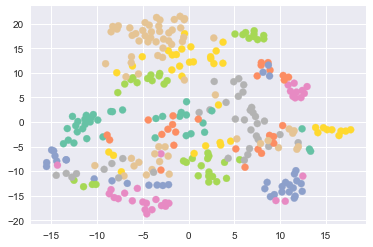

In [21]:
COLOR_DIGIT = 2

def plot_embedding(X_embedded, df_desc, idx2industry, COLOR_DIGIT):
    '''
    Plot embedding vector in 2D scatter plot
    Group the color by first 2 digit
    Input:
    - X_embedded: embedding vectors
    - df_desc:dataframe with industry description
    - idx2industry: dictionary mapping index to industry
    '''

    code_top_digit = set([code[:COLOR_DIGIT] for code in df_desc.Code.unique()])
    code_top_digit = sorted(list(code_top_digit))

    rgb_values = sns.color_palette("Set2", len(code_top_digit))
    color_map = dict(zip(code_top_digit, rgb_values))

    industry_l = [str(idx2industry[idx]) for idx, _ in enumerate(X_embedded)]
    color_l = [color_map.get(ind[:COLOR_DIGIT], rgb_values[-1]) for ind in industry_l]

    x = X_embedded[:,0]
    y = X_embedded[:,1]
    plt.scatter(x,y, c=color_l)

plot_embedding(X_embedded, df_desc, idx2industry, COLOR_DIGIT)

In [23]:
df_sim = evaluation.get_most_similar('4841', 10, embedding_vec, df_desc, industry2idx, idx2industry)
df_sim[['naics', 'distance', 'description']]

,naics,distance,description
0,4841,0.000000,General Freight Trucking
1,4889,0.921830,Other Support Activities for Transportation
2,4883,1.658117,Support Activities for Water Transportation
3,5324,1.671808,Commercial and Industrial Machinery and Equipm...
4,4931,1.746093,Warehousing and Storage
5,4851,2.021496,Urban Transit Systems
6,4831,2.036890,"Deep Sea, Coastal, and Great Lakes Water Trans..."
7,4884,2.092427,Support Activities for Road Transportation
8,5611,2.176778,Office Administrative Services
9,8111,2.200438,Automotive Repair and Maintenance


In [24]:
df_sim = evaluation.get_most_similar('1111', 10, embedding_vec, df_desc, industry2idx, idx2industry)
df_sim[['naics', 'distance', 'description']]

,naics,distance,description
0,1111,0.000000,Oilseed and Grain Farming
1,1113,0.736020,Fruit and Tree Nut Farming
2,1112,0.865366,Vegetable and Melon Farming
3,1129,0.938195,Other Animal Production
4,1121,1.073183,Cattle Ranching and Farming
5,1125,1.176194,Aquaculture
6,1114,1.277862,"Greenhouse, Nursery, and Floriculture Production"
7,1123,1.412860,Poultry and Egg Production
8,1151,1.678226,Support Activities for Crop Production
9,1141,1.750099,Fishing


In [25]:
df_sim = evaluation.get_most_similar('5231', 10, embedding_vec, df_desc, industry2idx, idx2industry)
df_sim[['naics', 'distance', 'description']]

,naics,distance,description
0,5231,0.000000,Securities and Commodity Contracts Intermediat...
1,5221,0.878938,Depository Credit Intermediation
2,5222,1.078533,Nondepository Credit Intermediation
3,5239,1.406253,Other Financial Investment Activities
4,5242,1.467337,"Agencies, Brokerages, and Other Insurance Rela..."
5,5511,2.057004,Management of Companies and Enterprises
6,5311,2.303207,Lessors of Real Estate
7,5416,2.309185,"Management, Scientific, and Technical Consulti..."
8,5223,2.488115,Activities Related to Credit Intermediation
9,5614,2.497818,Business Support Services
